In [2]:
import numpy as np
import random
from copy import deepcopy
import matplotlib.pyplot as plt
import torchvision, cv2
from utils.visualizations import plot_samples
from utils.transforms import *
import utils.dataset as ds

In [3]:
import utils.dataset as ds
import torchvision, cv2
import importlib
importlib.reload(ds)

physionet = ds.PhysionetDataset(train=True)
slp = ds.SLPDataset()
cifar = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)

Files already downloaded and verified


In [4]:
from utils.transforms import *
import utils.transforms as tf
import importlib
importlib.reload(tf)

physionet_zca = deepcopy(physionet)
slp_zca = deepcopy(slp)
cifar_zca = deepcopy(slp)
# physionet_zca.x = zca(physionet_zca.x, epsilon=0.1)
slp_zca.x = zca(slp_zca.x, epsilon=0.1)
np.save('./data/SLP/data_zca.npy', slp_zca.x)
# cifar_zca.data = zca(cifar_zca.data, epsilon=0.1)

(1000, 192, 84)
(1000, 16128)


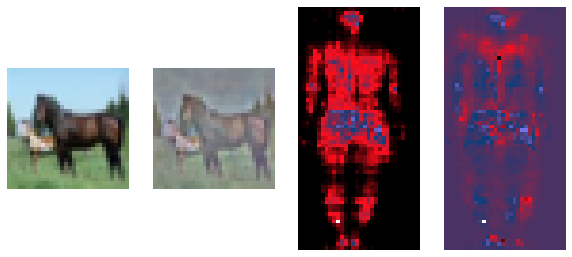

In [32]:
from utils.visualizations import *
import utils.visualizations as vi
import importlib
importlib.reload(vi)

image_row(cifar.data[12], zca_cifar[12], physionet.x[0], zca_physionet.x[0])

In [33]:
indices_per_class = {}
for i, label in enumerate(classes):
    indices = np.where(physionet.y == i)[0]
    indices_per_class[i] = indices
# print(indices_per_class)

In [34]:
sample_indices = [index for index in list(map(lambda c: random.choice(c) if len(c) > 0 else None, indices_per_class.values()))]
print(sample_indices)

[6351, 7225, 2700, 10185, 10256, 5022, 5618, 4230, None, None, None]


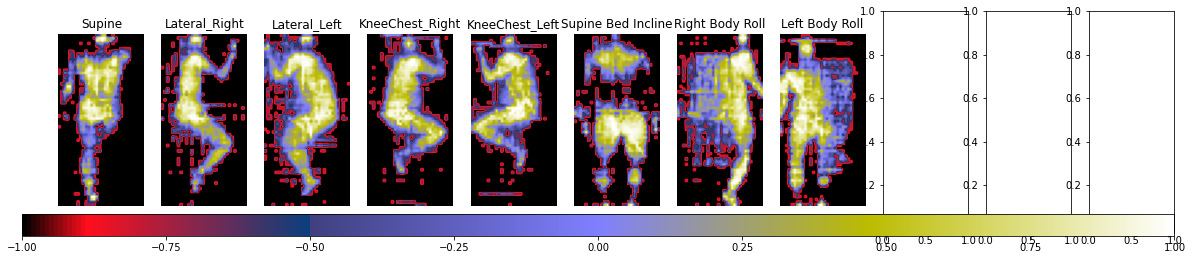

In [35]:
plot_samples(physionet, sample_indices, classes, torchvision.transforms.Compose([
        Normalize(),
        EqualizeHist(),
]))

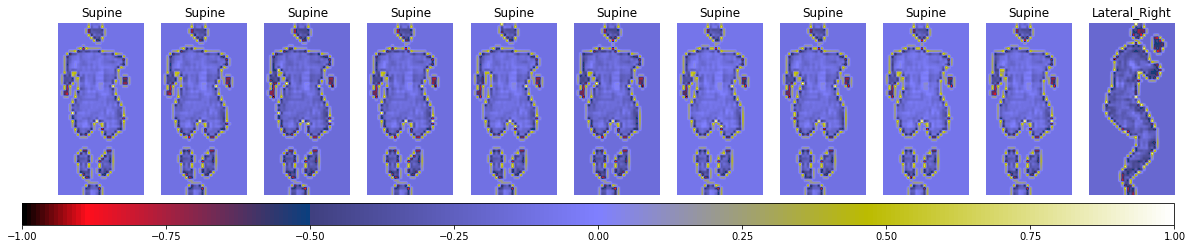

In [131]:
from utils.transforms import *
from utils.visualizations import *
import utils.transforms as tf
import utils.visualizations as vi
import importlib
importlib.reload(tf)
importlib.reload(vi)
import cv2

basic_transforms = [
    Normalize(),
    EqualizeHist(),
    Blur((3, 3)),
    Threshold(lambda img: np.median(img[img > 0.0])),
    Laplace(),
]
#cv2.Laplacian(physionet[0][0][0], cv2.CV_32F)
plot_samples(physionet, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 101], classes, transform = torchvision.transforms.Compose(
    basic_transforms,
))

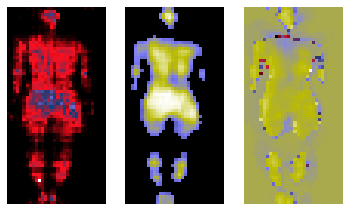

In [85]:
from utils.transforms import *
from utils.visualizations import *
import utils.transforms as tf
import utils.visualizations as vi
import importlib
importlib.reload(tf)
importlib.reload(vi)

transforms = torchvision.transforms.Compose([
    Normalize(),
    EqualizeHist(),
    Blur((3, 3)),
    Threshold(lambda img: np.median(img[img > 0.0])),
])

physionet_transformed = np.array(list(map(lambda i: i[0], [transforms(sample) for sample in physionet])))
zca_transformed_physionet = zca(physionet_transformed, epsilon=0.1)

image_row(physionet.x[0], physionet_transformed[0], zca_transformed_physionet[0])

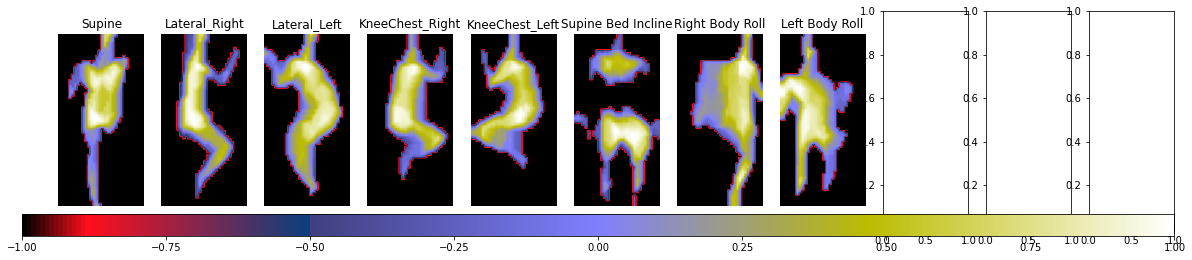

In [82]:
plot_samples(physionet, sample_indices, classes, transform = torchvision.transforms.Compose([
        *basic_transforms,
        Close((2,4), ktype=cv2.MORPH_CROSS, iterations=2),
        # Erode((2,2), ktype=cv2.MORPH_CROSS, iterations=2),
        #Close((3,3), ktype=cv2.MORPH_CROSS, iterations=2),
]))

0.0 0.006028962
(64, 32)


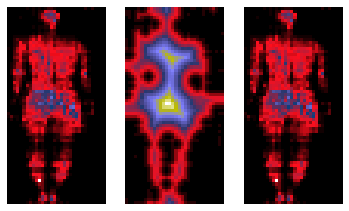

In [81]:
from utils.transforms import *
from utils.visualizations import *
import utils.transforms as tf
import utils.visualizations as vi
import importlib
importlib.reload(tf)
importlib.reload(vi)
from skimage import data

transforms = torchvision.transforms.Compose([
    Normalize(),
])

sample = transforms(physionet[0])
image = sample[0]
image = image.reshape(image.shape[1:])

background = tf.roll_ball(image, radius=75, normalized=True)
print(background.min(), background.max())
rolled_image = image-background
print(image.shape)
vi.image_row(image, background, rolled_image)

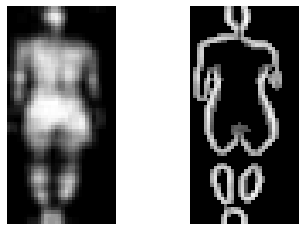

In [80]:
from utils.transforms import *
from utils.visualizations import *
import utils.transforms as tf
import utils.visualizations as vi
import importlib
importlib.reload(tf)
importlib.reload(vi)
from skimage import data, filters

transforms_base = [
    Normalize(),
    EqualizeHist(),
    Blur((3, 3)),
    Threshold(lambda img: np.median(img[img > 0.0])),
    Sobel(),
    #Blur((3, 3)),
    Threshold(lambda img: np.median(img[img > 0.0])),
]

base_transform = torchvision.transforms.Compose(transforms_base[:3])
sobel_transform = torchvision.transforms.Compose(transforms_base)

sample = base_transform(physionet[0])
sobel = sobel_transform(sample)

vi.image_row(sample[0], sobel[0], cmap="gray")

C:\Users\Jannis\AppData\Local\Temp\ipykernel_15068\1735997314.py:23: RuntimeWarning: divide by zero encountered in log
  manip_magnitude_spectrum = np.log(np.abs(fshift))


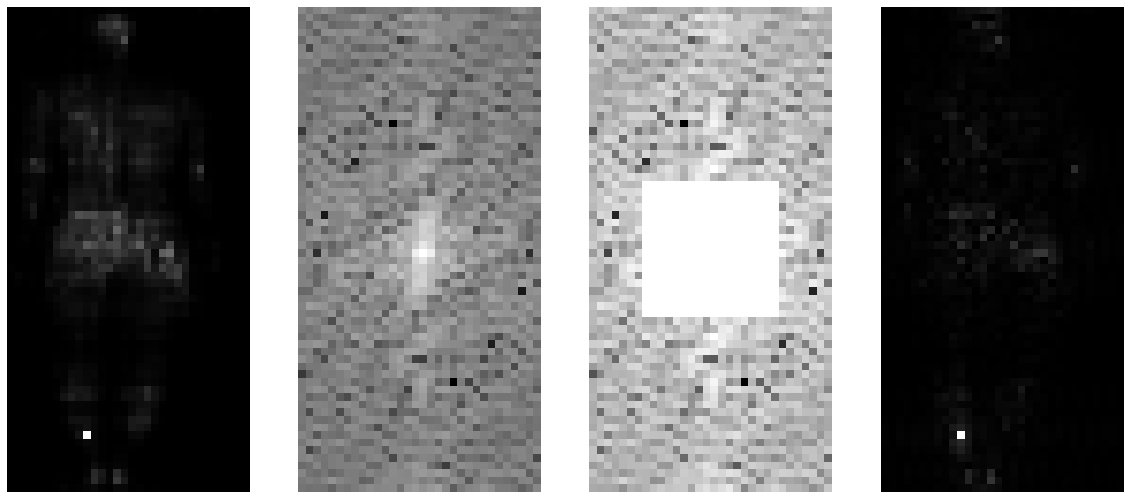

In [109]:
from utils.transforms import *
from utils.visualizations import *
import utils.transforms as tf
import utils.visualizations as vi
import importlib
importlib.reload(tf)
importlib.reload(vi)
from skimage import data, filters

image = physionet[0][0] #data.coins()
image = np.reshape(image, image.shape[1:])
f = np.fft.fft2(image)
fshift = np.fft.fftshift(f)
magnitude_spectrum = np.log(np.abs(fshift))

rows, cols = image.shape
crow,ccol = int(rows/2) , int(cols/2)
rect_rad = 9
keep = 100
#fshift[keep:rows-keep] = 0
#fshift[:, keep:cols-keep] = 0
fshift[crow-rect_rad:crow+rect_rad, ccol-rect_rad:ccol+rect_rad] = 0
manip_magnitude_spectrum = np.log(np.abs(fshift))
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

image_row(image, magnitude_spectrum, manip_magnitude_spectrum, img_back, cmap="gray", figsize=(20,20))